<font size=7 face="Courier">Maxwell Raw Data Feed - Source Code

This notebook is used to create a raw data feed form the MaxOne device. Code comes from [read_raw.py](/edit/Projects/Maxwell_Controller/closed_loop_2/edited_code/read_raw.py)

# <font color="grey"> Set Up Notebook

Import packages Alex's packages

In [1]:
import sys
import zmq
import struct
import array
import numpy as np

Import time. While debugging, we only show data every second so as to not flood the printed output.

In [2]:
import time

In [13]:
import matplotlib.pyplot as plt

In [23]:
#%matplotlib inline

# <font color="grey"> Helper Function - Socket Subscriber

Generate a subscriber socket with the same settings as the original C++ program.

In [3]:
def make_socket(port):
    '''
    Generate a subscriber socket with the same settings as the
    original C++ program.
    '''

    print(f'Acquiring socket {port}... ', end='', flush=True)
    subscriber = ctx.socket(zmq.SUB)
    subscriber.setsockopt(zmq.RCVHWM, 0)
    subscriber.setsockopt(zmq.RCVBUF, 10*20000*1030)
    subscriber.setsockopt_string(zmq.SUBSCRIBE, "")
    subscriber.setsockopt(zmq.RCVTIMEO, 100)
    subscriber.connect(f'tcp://localhost:{port}')

    more = True
    while more:
        try:
            msg = subscriber.recv()
        except zmq.ZMQError as e:
            continue
        more = subscriber.getsockopt(zmq.RCVMORE)
    #print('acquired.', flush=True)

    return subscriber

# <font color="blue">Raw Data Reader Function

In [4]:

ctx = zmq.Context.instance()

filt = make_socket(7205)
raw = make_socket(7204)
time_old = round( time.time() )

while True:
    # Sometimes the publisher will be interrupted, so don't let that
    # crash the entire program, just skip the frame.
    frame_number = frame_raw = events_data = filt_data = raw_data = weird_data = None
    try:
        # The first component of each message is the frame number as
        # a long long, so unpack that.
        frame_raw = struct.unpack('Q', raw.recv())[0]
        frame_number = struct.unpack('Q', filt.recv())[0]

        # Grab the frame data from both raw and filtered channels.
        if filt.getsockopt(zmq.RCVMORE):
            filt_data = filt.recv()
        if raw.getsockopt(zmq.RCVMORE):
            raw_data = raw.recv()

        # Only filtered has spike events; ignore these.
        if filt.getsockopt(zmq.RCVMORE):
            events_data = filt.recv()

        # Looking for extra data.
        if raw.getsockopt(zmq.RCVMORE):
            #print(frame_number)
            while raw.getsockopt(zmq.RCVMORE):
                weird_data = raw.recv()
                #print(f'There was more data, size {len(weird_data)}.')

    except Exception as e:
        print(e)  # ! What does this do?
        continue

    # `frame_data` is a 1027-element array containing the recorded voltage
    # at each electrode, so unpack that into a usable format.
    filt_arr = np.array(array.array('f', filt_data))
    raw_arr = np.array(array.array('f', raw_data))

    # Don't bother reading the events in this one, just check the size adn
    # frame number of the two floating-point data frames.
    time_new =  round( time.time() )
    if time_old < time_new:
        print(f'Frame #{frame_number} (raw #{frame_raw}, Δ={frame_raw-frame_number}):')
        print(f'  raw has {len(raw_arr)} points, from {raw_arr.min()} to {raw_arr.max()}')
        print(f' filt has {len(filt_arr)} points, from {filt_arr.min()} to {filt_arr.max()}')
        time_old = time_new

# If you split this code into multiple threads, e.g. to consolidate
# this script with the one that handles the recordings, it will be
# necessary to delete each subscriber to the ZMQ context separately
# using the usual Python operator `del`, and then terminate the
# context with `ctx.term()`. In a single-threaded script like this,
# though, it's fine to just let the Python interpreter run all these
# destructors when the program terminates.

Acquiring socket 7205... Acquiring socket 7204... Frame #1808505537 (raw #1808505600, Δ=63):
  raw has 1027 points, from -398.0 to 1000.0
 filt has 1027 points, from -0.5943862199783325 to 488.0
Frame #1808525614 (raw #1808525677, Δ=63):
  raw has 1027 points, from -399.0 to 1000.0
 filt has 1027 points, from -0.609379231929779 to 488.0
Frame #1808545601 (raw #1808545664, Δ=63):
  raw has 1027 points, from -399.0 to 1000.0
 filt has 1027 points, from -0.6906112432479858 to 488.0
Frame #1808565569 (raw #1808565632, Δ=63):
  raw has 1027 points, from -399.0 to 1000.0
 filt has 1027 points, from -0.4025176763534546 to 488.0
Frame #1808585537 (raw #1808585600, Δ=63):
  raw has 1027 points, from -399.0 to 1000.0
 filt has 1027 points, from -0.606167197227478 to 488.0
Frame #1808605628 (raw #1808605691, Δ=63):
  raw has 1027 points, from -399.0 to 1000.0
 filt has 1027 points, from -0.43338531255722046 to 488.0
Frame #1808625579 (raw #1808625642, Δ=63):
  raw has 1027 points, from -399.0 to 

KeyboardInterrupt: 

Run when finished so that we don't get an error message

In [5]:
del filt 
del raw
ctx.term()

In [9]:
len(raw_arr)

1027

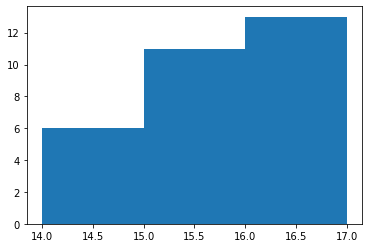

In [28]:
plt.hist( raw_arr.tolist()[:30],3 )
plt.show()

In [25]:
print(raw_arr.tolist())

[16.0, 17.0, 14.0, 15.0, 16.0, 17.0, 14.0, 15.0, 15.0, 17.0, 15.0, 15.0, 15.0, 16.0, 15.0, 15.0, 15.0, 16.0, 15.0, 14.0, 15.0, 16.0, 14.0, 14.0, 16.0, 17.0, 14.0, 16.0, 16.0, 16.0, 14.0, 16.0, 16.0, 17.0, 16.0, 15.0, 15.0, 16.0, 15.0, 14.0, 16.0, 17.0, 15.0, 14.0, 16.0, 17.0, 15.0, 14.0, 16.0, 17.0, 14.0, 16.0, 15.0, 17.0, 14.0, 16.0, 17.0, 16.0, 16.0, 15.0, 17.0, 16.0, 16.0, 15.0, 15.0, 17.0, 14.0, 15.0, 16.0, 17.0, 14.0, 14.0, 16.0, 17.0, 15.0, 15.0, 15.0, 17.0, 15.0, 15.0, 14.0, 16.0, 14.0, 15.0, 15.0, 16.0, 14.0, 15.0, 15.0, 17.0, 16.0, 15.0, 15.0, 17.0, 15.0, 15.0, 14.0, 15.0, 15.0, 15.0, -399.0, 15.0, 15.0, 15.0, 17.0, 17.0, 15.0, 14.0, 17.0, 16.0, 15.0, 14.0, 16.0, 16.0, 15.0, 16.0, 15.0, 16.0, 15.0, 15.0, 16.0, 17.0, 15.0, 15.0, 16.0, 17.0, 15.0, 14.0, 15.0, 17.0, 14.0, 15.0, 16.0, 17.0, 14.0, 16.0, 15.0, 16.0, 15.0, 16.0, 16.0, 17.0, 14.0, 15.0, 15.0, 15.0, 16.0, 15.0, 15.0, 16.0, 16.0, 16.0, 15.0, 16.0, 15.0, 15.0, 15.0, 17.0, 16.0, 15.0, 16.0, 16.0, 14.0, 14.0, 17.0, 17.0, 1

In [29]:
min(raw_arr)

-399.0

In [30]:
max(raw_arr)

1000.0

In [43]:
import numpy as np
from scipy import  stats
import pandas as pd

In [36]:
print(stats.describe(raw_arr.tolist()))

DescribeResult(nobs=1027, minmax=(-399.0, 1000.0), mean=16.122687439143135, variance=1113.8270383846668, skewness=23.106743812357003, kurtosis=757.2457103952752)


In [38]:
np.std(raw_arr)

33.357796

In [45]:
df = pd.DataFrame(raw_arr)
df.time_diff.quantile([0.25,0.5,0.75])

AttributeError: 'DataFrame' object has no attribute 'time_diff'

In [46]:
np.quantile( raw_arr, .25 )

15.0

In [47]:
np.quantile( raw_arr, .75 )

16.0